<a href="https://colab.research.google.com/github/marziye-jalili/deep_learning/blob/main/Pima_Indians_Diabetes_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Load libraries

In [52]:
# General libraries and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# Data preprocessing libraries
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

# Data splitting and feature selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_classif

# Performance metrics and evaluation
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, roc_curve, auc

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

#Read data

In [53]:
data = pd.read_csv('/content/veri-seti.csv')
print('Done!')

Done!


#**Data Analysis**

In [54]:
#data.head(10)
print(data.head(10).to_markdown(index=False))

|   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|--------------:|----------:|----------------:|----------------:|----------:|------:|---------------------------:|------:|----------:|
|             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|             0 |       137 |              40 |              35 |       168 |  43.1 |                      2.288 |    33 |         1 |
|             5 |       116 |              74 |        

In [55]:
data.shape

(768, 9)

In [56]:
data.rename(columns = {'DiabetesPedigreeFunction':'DPF',}, inplace = True)
data.rename(columns = {'BloodPressure':'BP','SkinThickness': 'SkinTh'}, inplace = True)

In [57]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Pregnancies  768 non-null    int64  
 1   Glucose      768 non-null    int64  
 2   BP           768 non-null    int64  
 3   SkinTh       768 non-null    int64  
 4   Insulin      768 non-null    int64  
 5   BMI          768 non-null    float64
 6   DPF          768 non-null    float64
 7   Age          768 non-null    int64  
 8   Outcome      768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


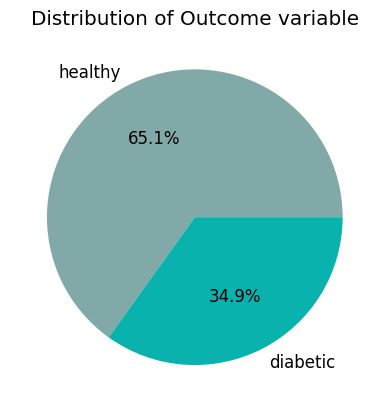

Outcome
0    500
1    268
dtype: int64

In [58]:
colors = ['#81a9a8', '#09b2ad']

# Pie chart
plt.pie(data['Outcome'].value_counts(), labels=['healthy', 'diabetic'], autopct='%1.1f%%', colors=colors)
plt.title('Distribution of Outcome variable')
plt.show()
data.groupby("Outcome").size()

###`The above graph shows that the data is unbalanced`

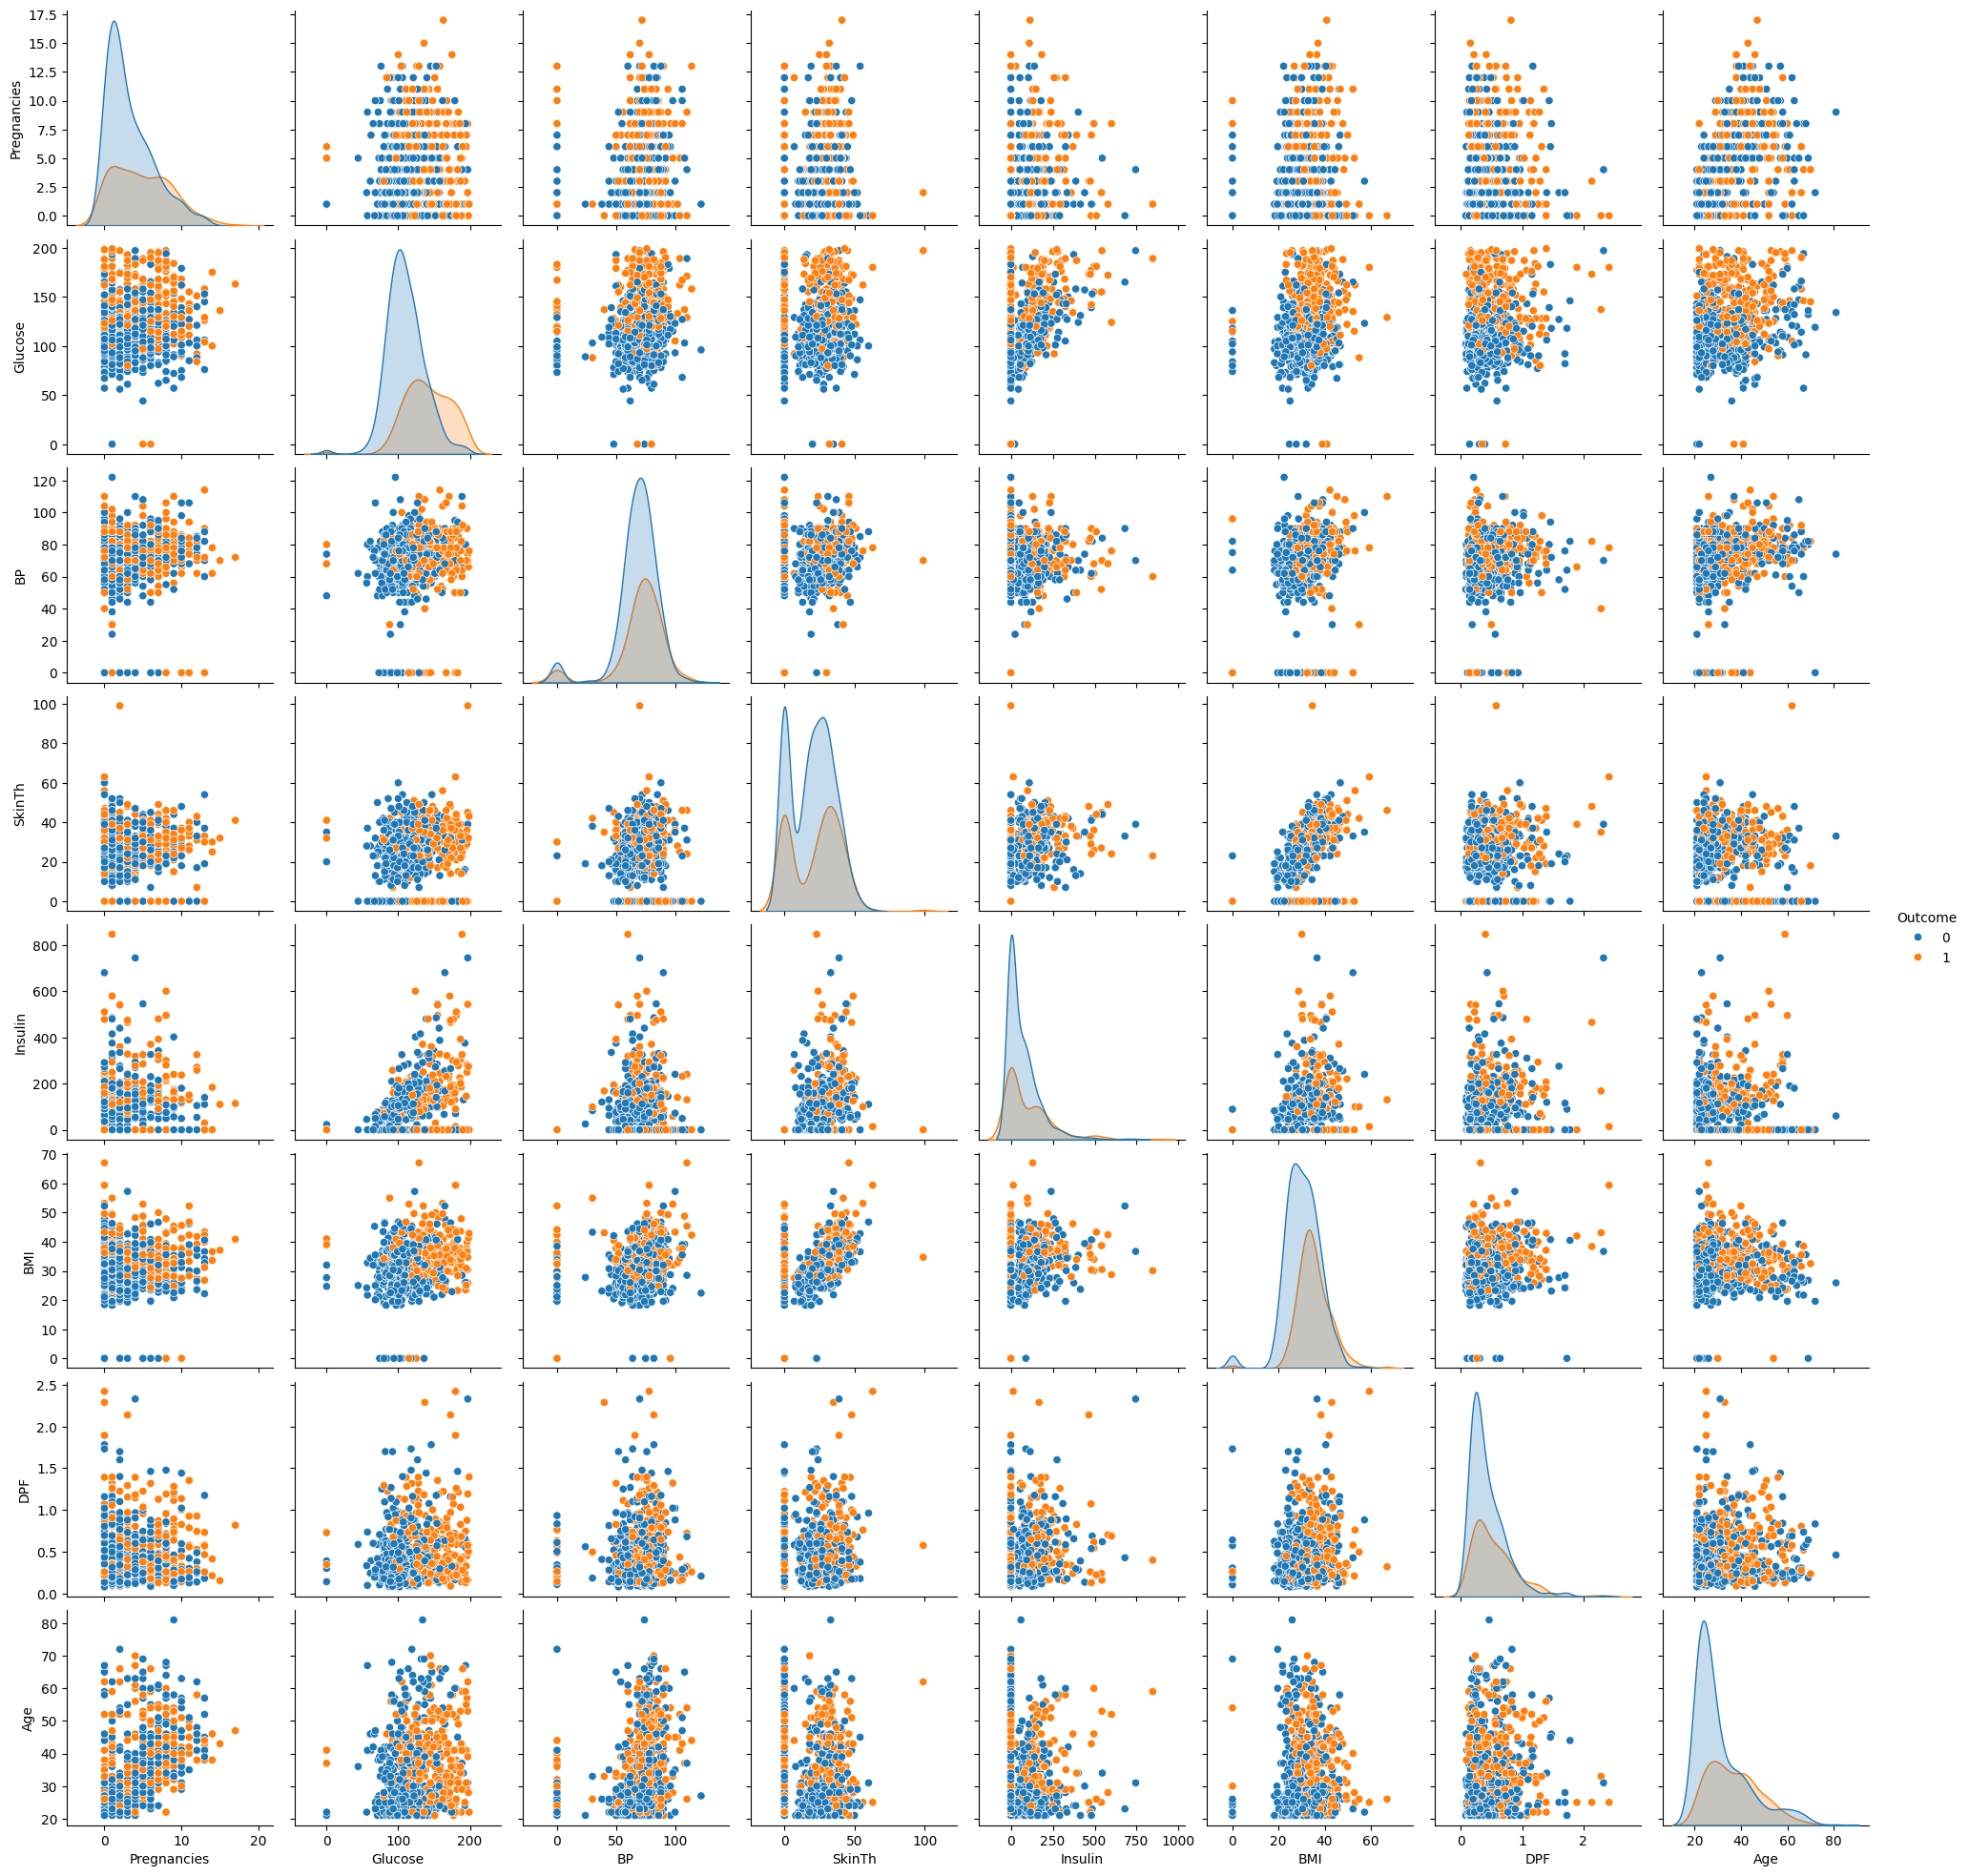

In [8]:
#Pair plot
sns.pairplot(data, hue = 'Outcome')

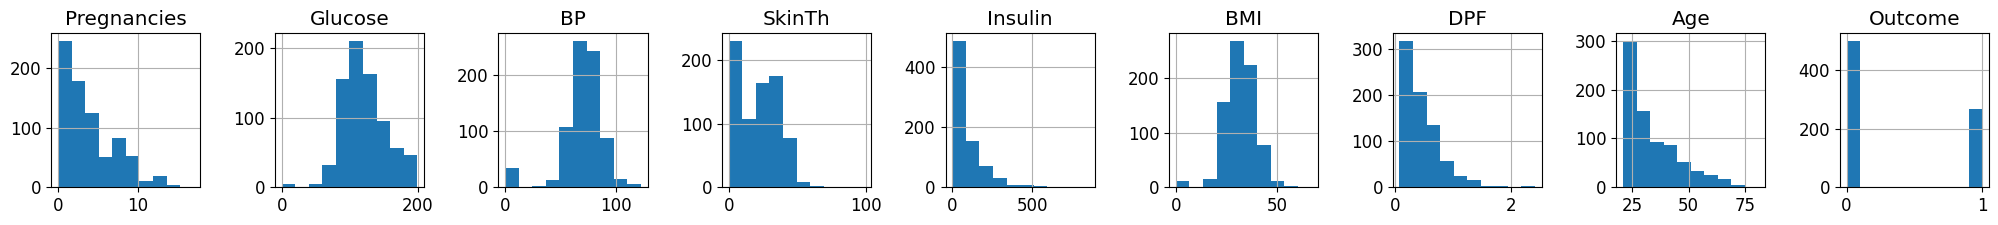

In [59]:
plt.rcParams.update({'font.size': 12})
data.hist(figsize=(25, 2), layout=(1, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

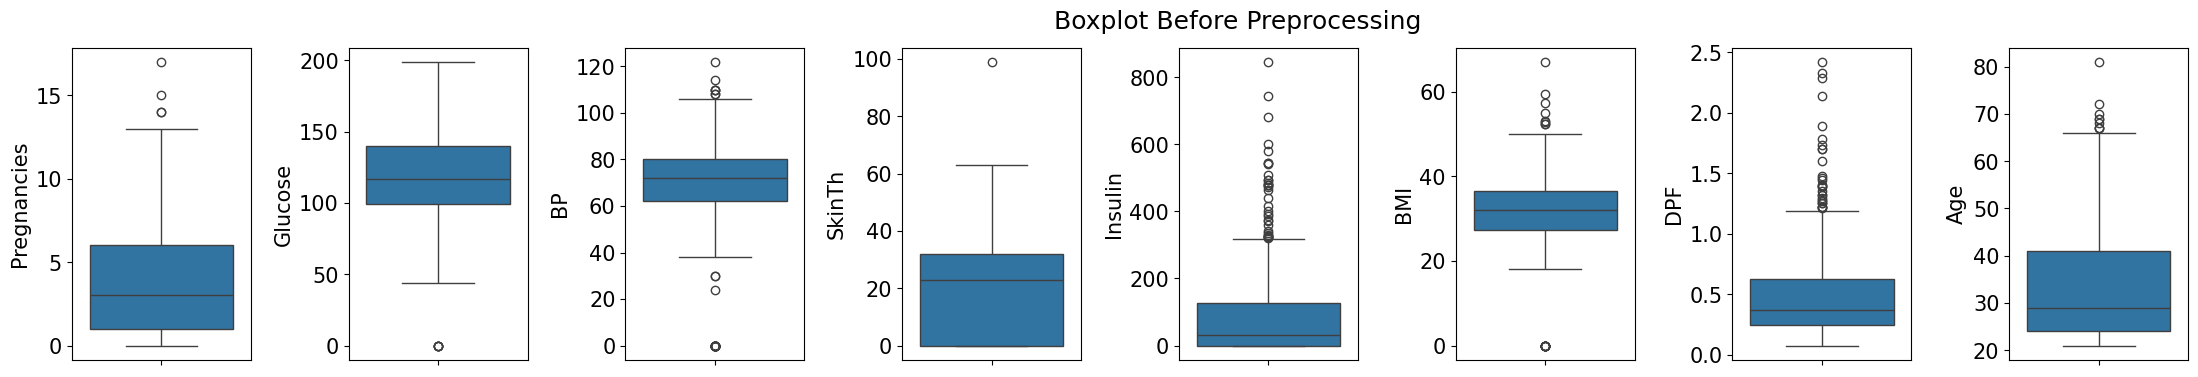

In [60]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(25, 4))
for i, col in enumerate(data.columns):
    if col != 'Outcome':
        plt.subplot(1, 9, i + 1)
        sns.boxplot(y=data[col], data=data)
        plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Boxplot Before Preprocessing', fontsize=18)
plt.show()


#**Checking , Removing Outliersand and Normalizing the Dataset**

In [61]:
#data.describe().T
print(data.describe().transpose().to_markdown())

|             |   count |       mean |        std |    min |      25% |      50% |       75% |    max |
|:------------|--------:|-----------:|-----------:|-------:|---------:|---------:|----------:|-------:|
| Pregnancies |     768 |   3.84505  |   3.36958  |  0     |  1       |   3      |   6       |  17    |
| Glucose     |     768 | 120.895    |  31.9726   |  0     | 99       | 117      | 140.25    | 199    |
| BP          |     768 |  69.1055   |  19.3558   |  0     | 62       |  72      |  80       | 122    |
| SkinTh      |     768 |  20.5365   |  15.9522   |  0     |  0       |  23      |  32       |  99    |
| Insulin     |     768 |  79.7995   | 115.244    |  0     |  0       |  30.5    | 127.25    | 846    |
| BMI         |     768 |  31.9926   |   7.88416  |  0     | 27.3     |  32      |  36.6     |  67.1  |
| DPF         |     768 |   0.471876 |   0.331329 |  0.078 |  0.24375 |   0.3725 |   0.62625 |   2.42 |
| Age         |     768 |  33.2409   |  11.7602   | 21     | 24 

######Replace missing values with the median for 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'

In [62]:
# Copy data to preserve the original
data_copy = data.copy()
data_copy[['Glucose', 'BP', 'SkinTh', 'Insulin', 'BMI']] = data_copy[['Glucose', 'BP', 'SkinTh', 'Insulin', 'BMI']].replace(0, np.nan)
print(data_copy.isnull().sum())

Pregnancies      0
Glucose          5
BP              35
SkinTh         227
Insulin        374
BMI             11
DPF              0
Age              0
Outcome          0
dtype: int64


In [63]:
data_copy.fillna(data_copy.median(), inplace=True)
print(data_copy.describe().transpose().to_markdown())


|             |   count |       mean |       std |    min |       25% |      50% |       75% |    max |
|:------------|--------:|-----------:|----------:|-------:|----------:|---------:|----------:|-------:|
| Pregnancies |     768 |   3.84505  |  3.36958  |  0     |   1       |   3      |   6       |  17    |
| Glucose     |     768 | 121.656    | 30.4383   | 44     |  99.75    | 117      | 140.25    | 199    |
| BP          |     768 |  72.3867   | 12.0966   | 24     |  64       |  72      |  80       | 122    |
| SkinTh      |     768 |  29.1081   |  8.79122  |  7     |  25       |  29      |  32       |  99    |
| Insulin     |     768 | 140.672    | 86.3831   | 14     | 121.5     | 125      | 127.25    | 846    |
| BMI         |     768 |  32.4552   |  6.87518  | 18.2   |  27.5     |  32.3    |  36.6     |  67.1  |
| DPF         |     768 |   0.471876 |  0.331329 |  0.078 |   0.24375 |   0.3725 |   0.62625 |   2.42 |
| Age         |     768 |  33.2409   | 11.7602   | 21     |  24 

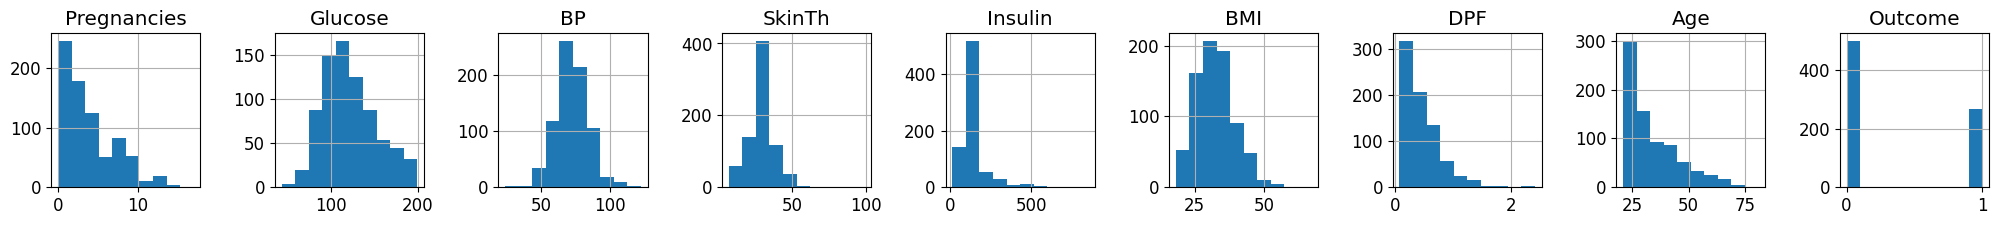

In [64]:
plt.rcParams.update({'font.size': 12})
data_copy.hist(figsize=(25, 2), layout=(1, 9))
plt.subplots_adjust(hspace=0.3, wspace=0.5)
plt.show()

#Removing Outliersand and Normalizing the Dataset

#Normalize the data

In [65]:
X = pd.DataFrame(data_copy.drop(["Outcome"],axis = 1),)
y = data_copy.Outcome

# Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(X)
data_scaled = pd.DataFrame(data_scaled, columns=X.columns)
print(data_scaled.describe().transpose().to_markdown())

|             |   count |         mean |     std |      min |       25% |        50% |       75% |     max |
|:------------|--------:|-------------:|--------:|---------:|----------:|-----------:|----------:|--------:|
| Pregnancies |     768 | -6.4763e-17  | 1.00065 | -1.14185 | -0.844885 | -0.250952  |  0.639947 | 3.90658 |
| Glucose     |     768 |  4.62593e-18 | 1.00065 | -2.55293 | -0.720163 | -0.153073  |  0.611265 | 2.54266 |
| BP          |     768 |  5.78241e-18 | 1.00065 | -4.00262 | -0.693761 | -0.0319899 |  0.629782 | 4.10408 |
| SkinTh      |     768 | -1.52656e-16 | 1.00065 | -2.51643 | -0.467597 | -0.0123013 |  0.329171 | 7.95538 |
| Insulin     |     768 |  1.50343e-17 | 1.00065 | -1.46735 | -0.222085 | -0.181541  | -0.155477 | 8.17044 |
| BMI         |     768 |  2.61365e-16 | 1.00065 | -2.07478 | -0.721209 | -0.0225899 |  0.603256 | 5.0424  |
| DPF         |     768 |  2.45174e-16 | 1.00065 | -1.18955 | -0.688969 | -0.300128  |  0.466227 | 5.88356 |
| Age         |    


###Winsorization



In [66]:
# Remove outliers using Winsorization method

data_scaled['Pregnancies'] = winsorize(data_scaled['Pregnancies'], limits=[0.001, 0.05])
data_scaled['Glucose'] = winsorize(data_scaled['Glucose'], limits=[0.001, 0.02])
data_scaled['BP'] = winsorize(data_scaled['BP'], limits=[0.06, 0.06])
data_scaled['SkinTh'] = winsorize(data_scaled['SkinTh'], limits=[0.051, 0.09])
data_scaled['Insulin'] = winsorize(data_scaled['Insulin'], limits=[0.23, 0.23])
data_scaled['BMI'] = winsorize(data_scaled['BMI'], limits=[0.05, 0.05])
data_scaled['DPF'] = winsorize(data_scaled['DPF'], limits=[0.00001, 0.05])
data_scaled['Age'] = winsorize(data_scaled['Age'], limits=[0.00001, 0.04])

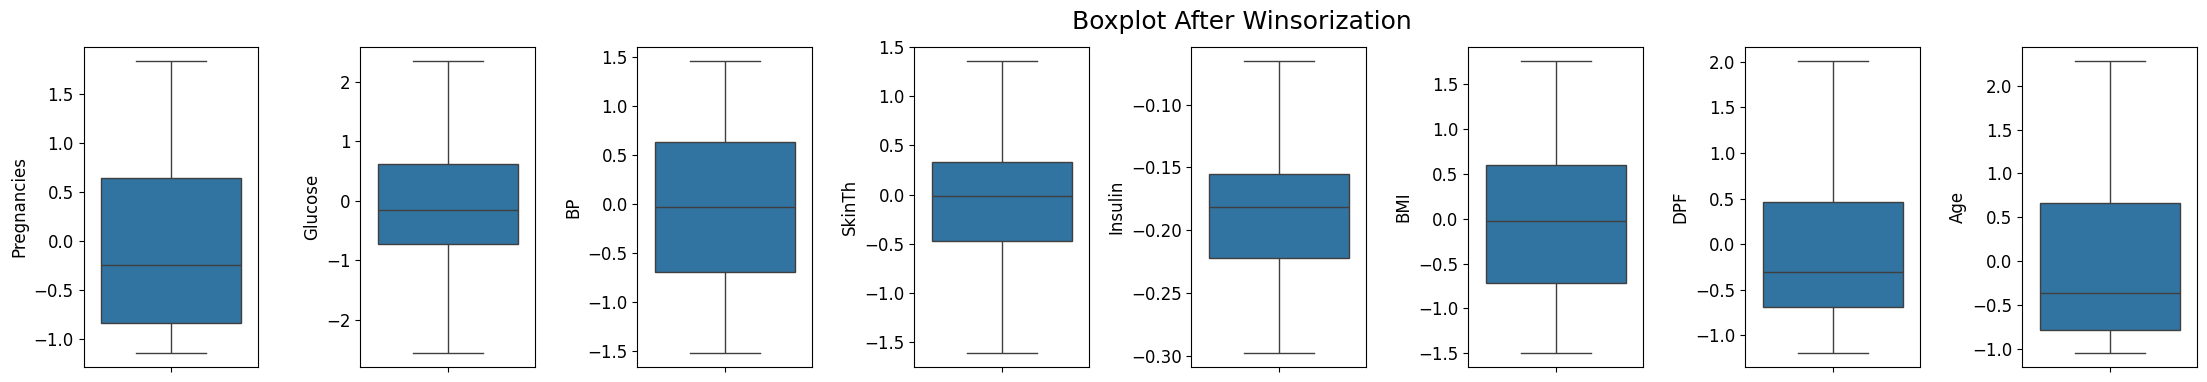

In [67]:
# Boxplot after preprocessing
plt.figure(figsize=(25, 4))

for i, col in enumerate(data_scaled.columns):
    if col != 'Outcome':
        plt.subplot(1, 9, i + 1)
        sns.boxplot(y=data_scaled[col], data=data_scaled)
        plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Boxplot After Winsorization', fontsize=18)
plt.show()

#**Split the preprocessed data into train and test sets**

In [68]:
# Splitting the original scaled data into training and testing sets with stratify
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(data_scaled, y, test_size=0.3, stratify=y, random_state=43)

In [69]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)

(537, 8)
(231, 8)


#**Basic Classification Models**

In [70]:
# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    conf_matrix = confusion_matrix(y_test, predictions)
    return accuracy, report, conf_matrix, model

# Function to plot ROC curve
def plot_roc_curve(model, X_test, y_test, ax, title):
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = auc(fpr, tpr)
    ax.plot(fpr, tpr, label="AUC="+str(auc_score))
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve - {title}')
    ax.legend(loc=4)

# Function to calculate error rates during cross-validation
def calculate_error_rates(model, X, y, cv):
    error_rates = []
    for train_index, test_index in cv.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        error_rate = 1 - accuracy_score(y_test, predictions)
        error_rates.append(error_rate)
    return error_rates

# Function to plot error rates
def plot_error_rates(error_rates, ax, title):
    ax.plot(range(1, len(error_rates) + 1), error_rates, marker='o')
    ax.set_xlabel('Fold')
    ax.set_ylabel('Error Rate')
    ax.set_title(f'Error Rate per Fold - {title}')
    ax.grid()

#**1. Naive bayes Model**

Naive Bayes Accuracy: 0.7835497835497836
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       150
           1       0.69      0.69      0.69        81

    accuracy                           0.78       231
   macro avg       0.76      0.76      0.76       231
weighted avg       0.78      0.78      0.78       231



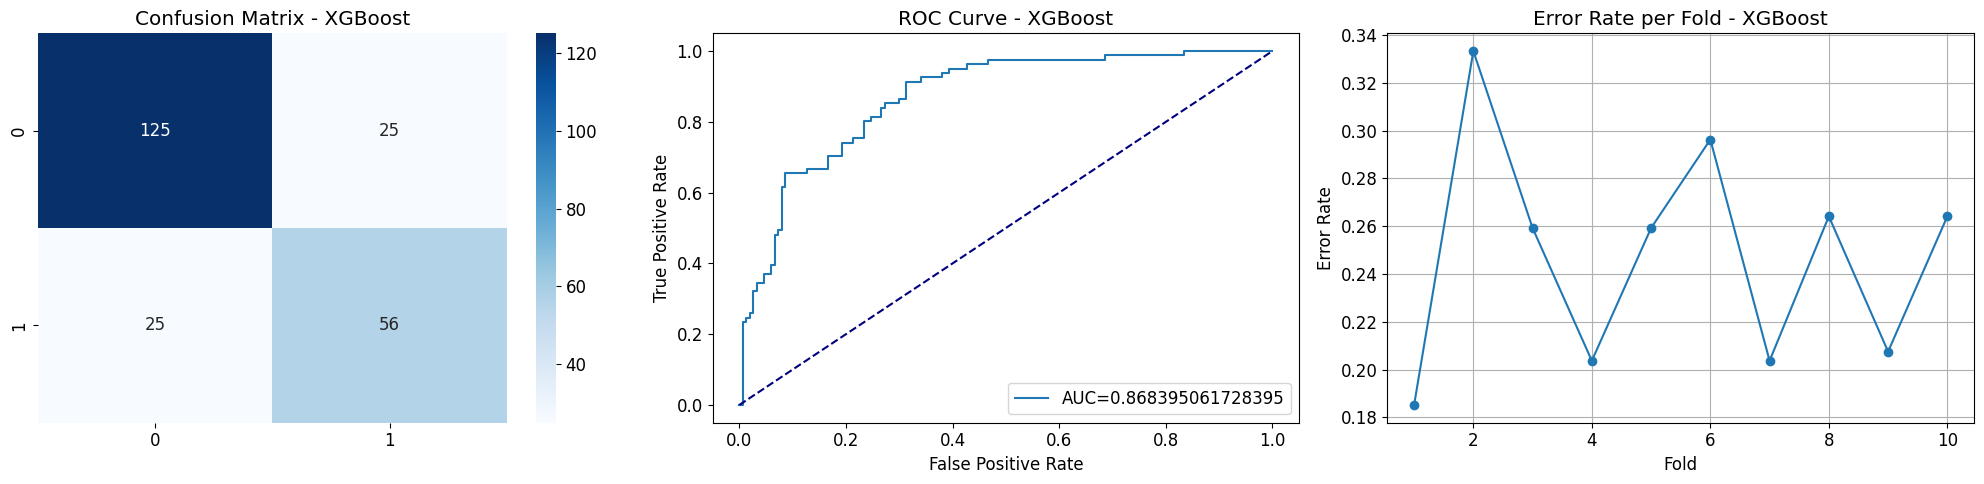

In [113]:
# Naive Bayes
nb_classifier = GaussianNB()
nb_accuracy, nb_report, nb_conf_matrix, nb_model = evaluate_model(nb_classifier, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("Naive Bayes Accuracy:", nb_accuracy)
print(nb_report)


# Create subplots for XGBoost
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for XGBoost
sns.heatmap(pd.DataFrame(nb_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - XGBoost")

# Plot ROC Curve for XGBoost
plot_roc_curve(nb_model, X_test_scaled, y_test_scaled, ax[1], "XGBoost")

# Calculate and plot error rates during cross-validation for XGBoost
error_rates_xgb = calculate_error_rates(nb_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_xgb, ax[2], "XGBoost")

plt.tight_layout()
plt.show()


#**2. K - Nearest Neighbors**

Best k value: 9
KNN Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       150
           1       0.66      0.62      0.64        81

    accuracy                           0.75       231
   macro avg       0.73      0.72      0.73       231
weighted avg       0.75      0.75      0.75       231



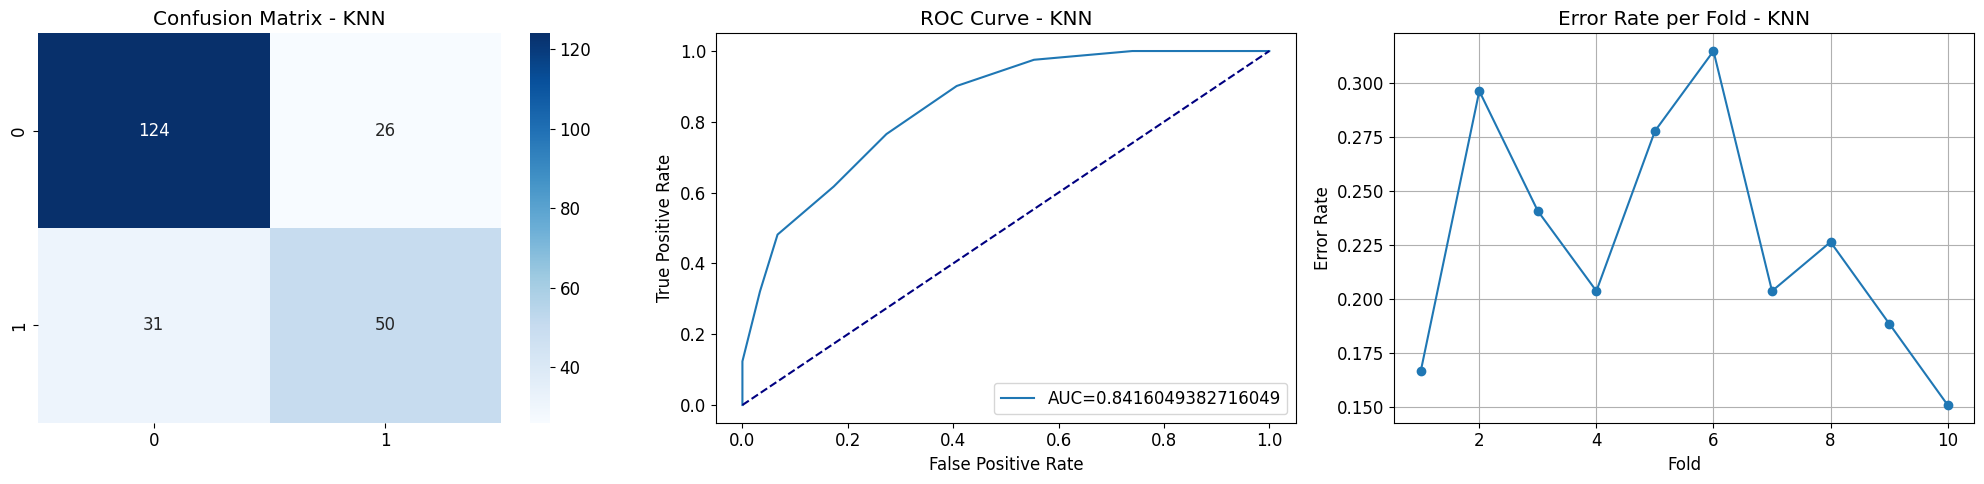

In [94]:
# Convert to numpy arrays if they are not already
if isinstance(X_train_scaled, pd.DataFrame):
    X_train_scaled = X_train_scaled.values
    X_test_scaled = X_test_scaled.values

if isinstance(y_train_scaled, pd.Series):
    y_train_scaled = y_train_scaled.values
    y_test_scaled = y_test_scaled.values

# Finding the best k for KNN using GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 40)}
knn = KNeighborsClassifier()
knn_gscv = GridSearchCV(knn, param_grid, cv=10)
knn_gscv.fit(X_train_scaled, y_train_scaled)

# Best k value
best_k = knn_gscv.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

# Evaluate KNN with the best k value
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_accuracy, knn_report, knn_conf_matrix, knn_model = evaluate_model(knn_best, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("KNN Accuracy:", knn_accuracy)
print(knn_report)

# Create subplots for KNN
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix
sns.heatmap(pd.DataFrame(knn_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - KNN")

# Plot ROC Curve
plot_roc_curve(knn_model, X_test_scaled, y_test_scaled, ax[1], "KNN")

# Calculate and plot error rates during cross-validation
error_rates = calculate_error_rates(knn_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates, ax[2], "KNN")

plt.tight_layout()
plt.show()

#**3. MLP (Multi-layer Perceptron)**

In [75]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['logistic', 'tanh', 'relu'],
    'alpha': [0.0001, 0.001, 0.01],
}

# Create the grid search
grid_search = GridSearchCV(MLPClassifier(max_iter=4000, random_state=43), param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search.fit(X_train_scaled, y_train_scaled)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Use the best model for prediction
best_model = grid_search.best_estimator_
best_model_accuracy = best_model.score(X_test_scaled, y_test_scaled)
print("Best Model Accuracy:", best_model_accuracy)


Best Parameters: {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
Best Model Accuracy: 0.683982683982684


MLP Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       150
           1       0.73      0.64      0.68        81

    accuracy                           0.79       231
   macro avg       0.78      0.76      0.76       231
weighted avg       0.79      0.79      0.79       231



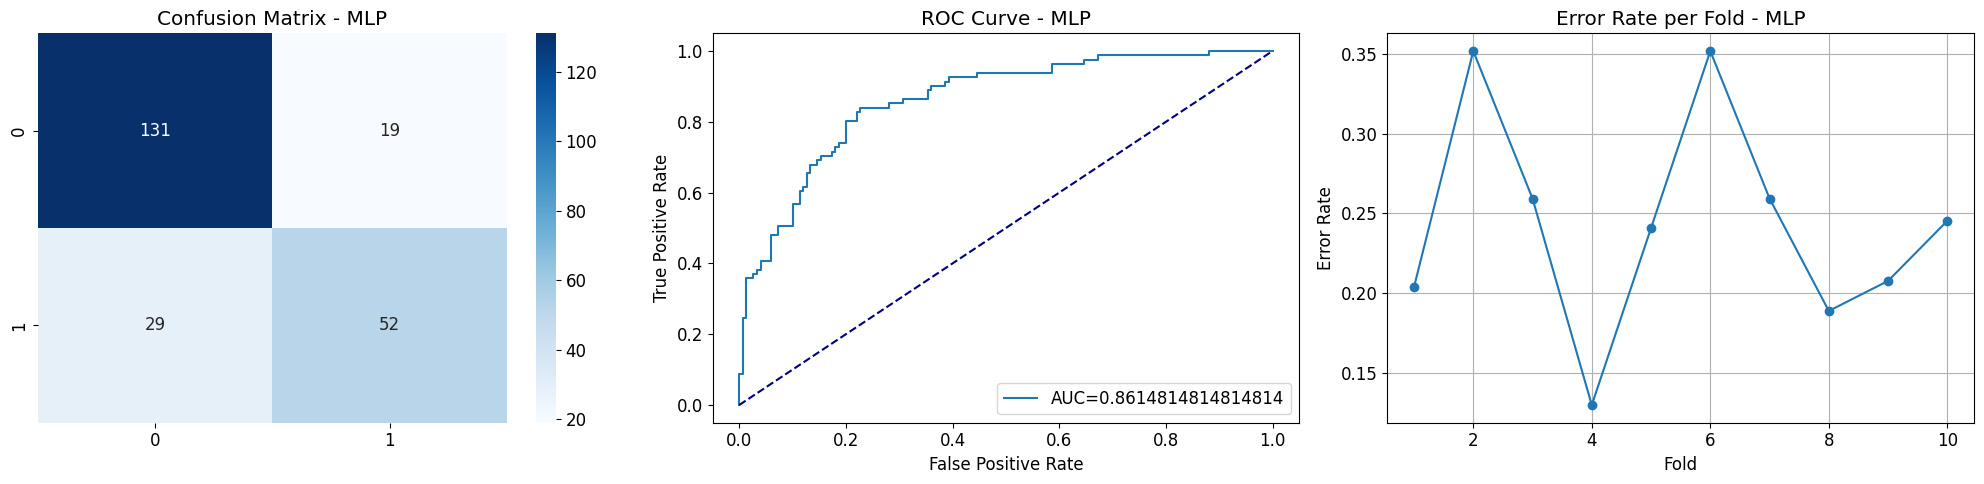

In [106]:
# Define the MLP classifier with best parameters
mlp_classifier = MLPClassifier(max_iter=4000, learning_rate_init=0.0001, random_state=43, alpha=0.0001, hidden_layer_sizes=(50,), activation='tanh')

# Evaluate the model with best parameters
mlp_accuracy, mlp_report, mlp_conf_matrix, mlp_model = evaluate_model(mlp_classifier, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("MLP Accuracy:", mlp_accuracy)
print(mlp_report)

# Create subplots for MLP
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix
sns.heatmap(pd.DataFrame(mlp_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - MLP")

# Plot ROC Curve
plot_roc_curve(mlp_model, X_test_scaled, y_test_scaled, ax[1], "MLP")

# Calculate and plot error rates during cross-validation
error_rates = calculate_error_rates(mlp_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates, ax[2], "MLP")

plt.tight_layout()
plt.show()

#**4. Support Vector Machines (SVM)**

In [77]:
# Define the parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}
# Create the grid search for SVM
grid_search_svm = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search_svm.fit(X_train_scaled, y_train_scaled)

# Get the best parameters for SVM
best_params_svm = grid_search_svm.best_params_
print("Best Parameters for SVM:", best_params_svm)

Best Parameters for SVM: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}


SVM Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       150
           1       0.79      0.56      0.65        81

    accuracy                           0.79       231
   macro avg       0.79      0.74      0.75       231
weighted avg       0.79      0.79      0.78       231



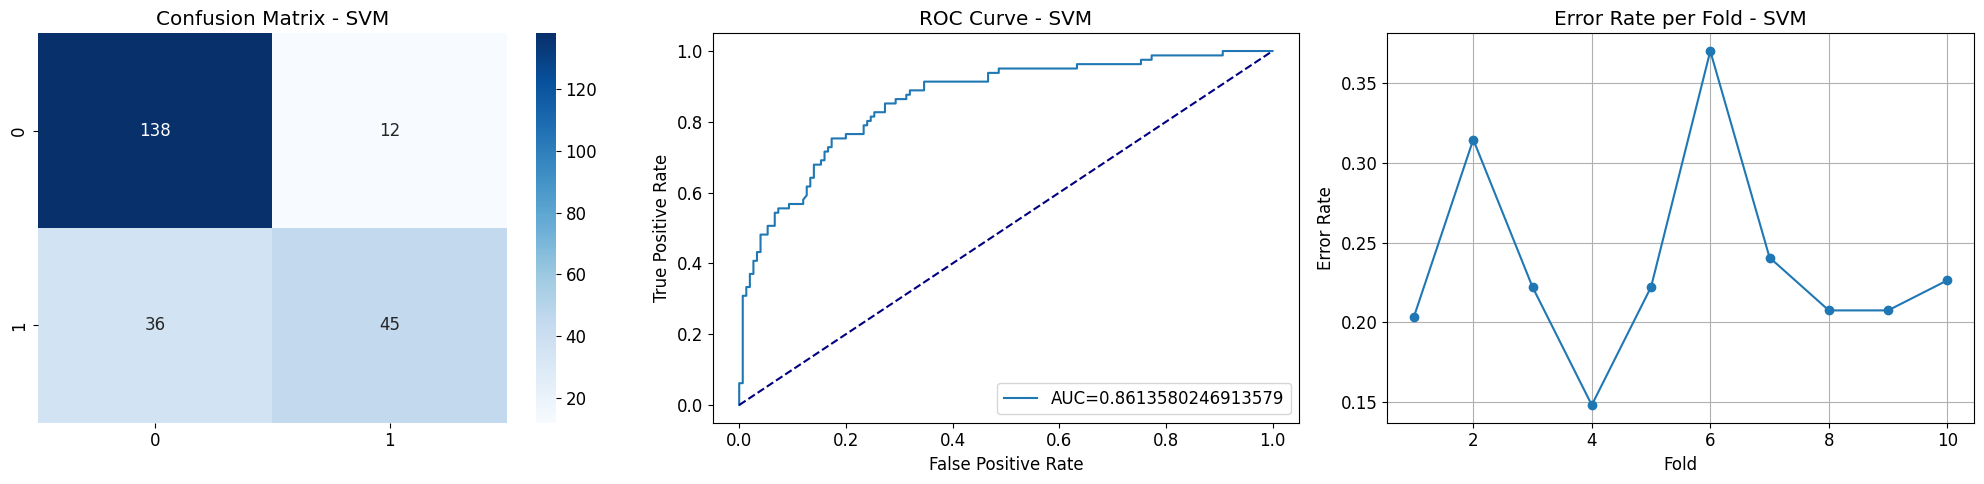

In [103]:
# Define the best model for SVM with the best parameters
best_svm_model = SVC(C=1, gamma=0.01, kernel='rbf', probability=True)

# Evaluate the best SVM model
svm_accuracy, svm_report, svm_conf_matrix, svm_model = evaluate_model(best_svm_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("SVM Accuracy:", svm_accuracy)
print(svm_report)

# Create subplots for SVM
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for SVM
sns.heatmap(pd.DataFrame(svm_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - SVM")

# Plot ROC Curve for SVM
plot_roc_curve(svm_model, X_test_scaled, y_test_scaled, ax[1], "SVM")

# Calculate and plot error rates during cross-validation for SVM
error_rates_svm = calculate_error_rates(svm_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_svm, ax[2], "SVM")

plt.tight_layout()
plt.show()

#**5. Extreme Gradient Boosting(XGBoost)**

In [79]:
# Define the parameter grid for XGBoost
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Create the grid search for XGBoost
grid_search_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy')

# Perform the grid search
grid_search_xgb.fit(X_train_scaled, y_train_scaled)

# Get the best parameters for XGBoost
best_params_xgb = grid_search_xgb.best_params_
print("Best Parameters for XGBoost:", best_params_xgb)

Best Parameters for XGBoost: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'subsample': 0.6}


XGBoost Accuracy: 0.7532467532467533
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       150
           1       0.67      0.59      0.63        81

    accuracy                           0.75       231
   macro avg       0.73      0.72      0.72       231
weighted avg       0.75      0.75      0.75       231



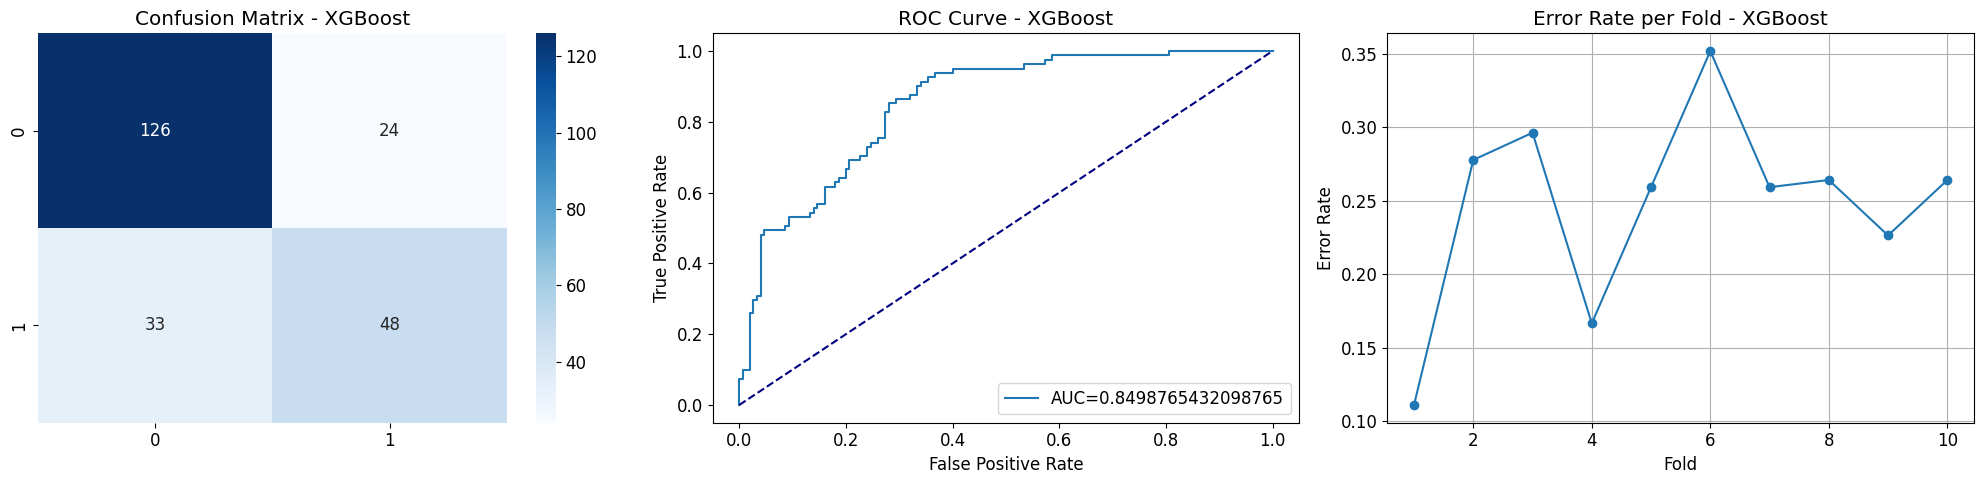

In [108]:

#best_xgb_model = xgb.XGBClassifier(colsample_bytree=0.6, learning_rate=0.001, max_depth=, n_estimators=50, subsample=1.0, use_label_encoder=False, eval_metric='logloss')

best_xgb_model = grid_search_xgb.best_estimator_
xgb_accuracy, xgb_report, xgb_conf_matrix, xgb_model = evaluate_model(best_xgb_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("XGBoost Accuracy:", xgb_accuracy)
print(xgb_report)

# Create subplots for XGBoost
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for XGBoost
sns.heatmap(pd.DataFrame(xgb_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - XGBoost")

# Plot ROC Curve for XGBoost
plot_roc_curve(xgb_model, X_test_scaled, y_test_scaled, ax[1], "XGBoost")

# Calculate and plot error rates during cross-validation for XGBoost
error_rates_xgb = calculate_error_rates(xgb_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_xgb, ax[2], "XGBoost")

plt.tight_layout()
plt.show()

#**6. Linear Discriminant Analysis (LDA)**

LDA Accuracy: 0.7705627705627706
              precision    recall  f1-score   support

           0       0.79      0.89      0.83       150
           1       0.73      0.56      0.63        81

    accuracy                           0.77       231
   macro avg       0.76      0.72      0.73       231
weighted avg       0.77      0.77      0.76       231



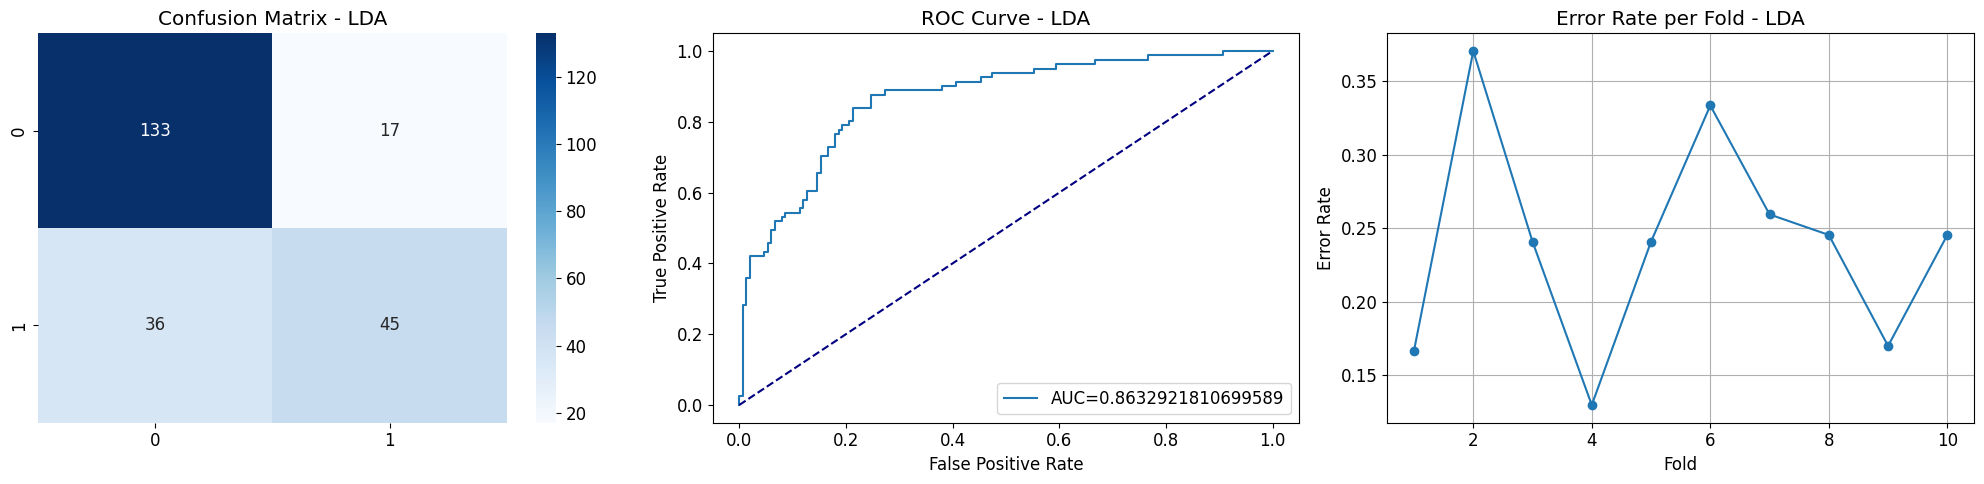

In [109]:
# Define the LDA model
lda_model = LinearDiscriminantAnalysis()

# Evaluate the LDA model
lda_accuracy, lda_report, lda_conf_matrix, lda_model = evaluate_model(lda_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("LDA Accuracy:", lda_accuracy)
print(lda_report)

# Create subplots for LDA
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for LDA
sns.heatmap(pd.DataFrame(lda_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - LDA")

# Plot ROC Curve for LDA
plot_roc_curve(lda_model, X_test_scaled, y_test_scaled, ax[1], "LDA")

# Calculate and plot error rates during cross-validation for LDA
error_rates_lda = calculate_error_rates(lda_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_lda, ax[2], "LDA")

plt.tight_layout()
plt.show()

#**7. Logistic Regression**

Logistic Regression Accuracy: 0.7922077922077922
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       150
           1       0.81      0.53      0.64        81

    accuracy                           0.79       231
   macro avg       0.80      0.73      0.75       231
weighted avg       0.80      0.79      0.78       231



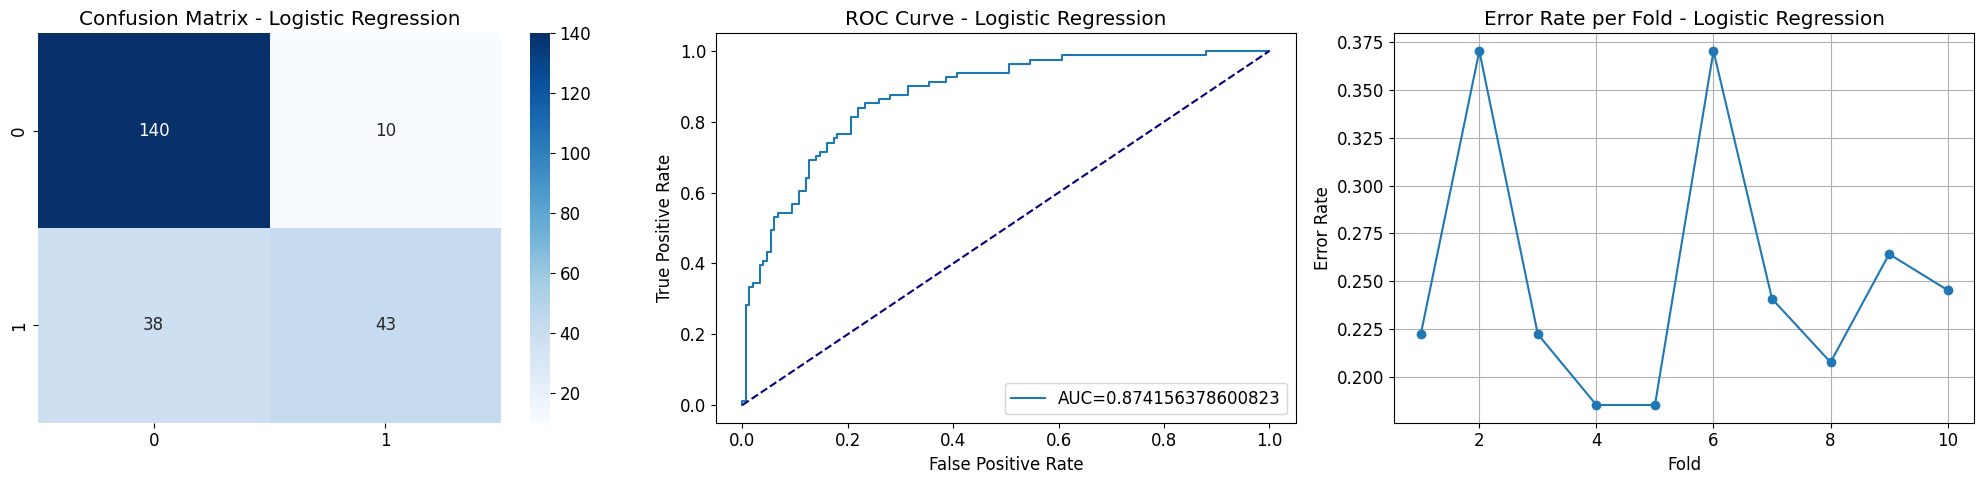

In [110]:
# Use the best model for Logistic Regression
best_log_reg_model = LogisticRegression(C=0.01, solver='lbfgs', random_state=43)

# Evaluate the best Logistic Regression model
log_reg_accuracy, log_reg_report, log_reg_conf_matrix, log_reg_model = evaluate_model(best_log_reg_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("Logistic Regression Accuracy:", log_reg_accuracy)
print(log_reg_report)

# Create subplots for Logistic Regression
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for Logistic Regression
sns.heatmap(pd.DataFrame(log_reg_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - Logistic Regression")

# Plot ROC Curve for Logistic Regression
plot_roc_curve(log_reg_model, X_test_scaled, y_test_scaled, ax[1], "Logistic Regression")

# Calculate and plot error rates during cross-validation for Logistic Regression
error_rates_log_reg = calculate_error_rates(log_reg_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_log_reg, ax[2], "Logistic Regression")

plt.tight_layout()
plt.show()

#**8. Random Forest**

In [111]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Perform Grid Search for Random Forest
rf = RandomForestClassifier(random_state=43)
grid_search_rf = GridSearchCV(rf, param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_scaled, y_train_scaled)

# Print the best parameters and best model accuracy
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


Random Forest Accuracy: 0.7662337662337663
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       150
           1       0.68      0.62      0.65        81

    accuracy                           0.77       231
   macro avg       0.74      0.73      0.74       231
weighted avg       0.76      0.77      0.76       231



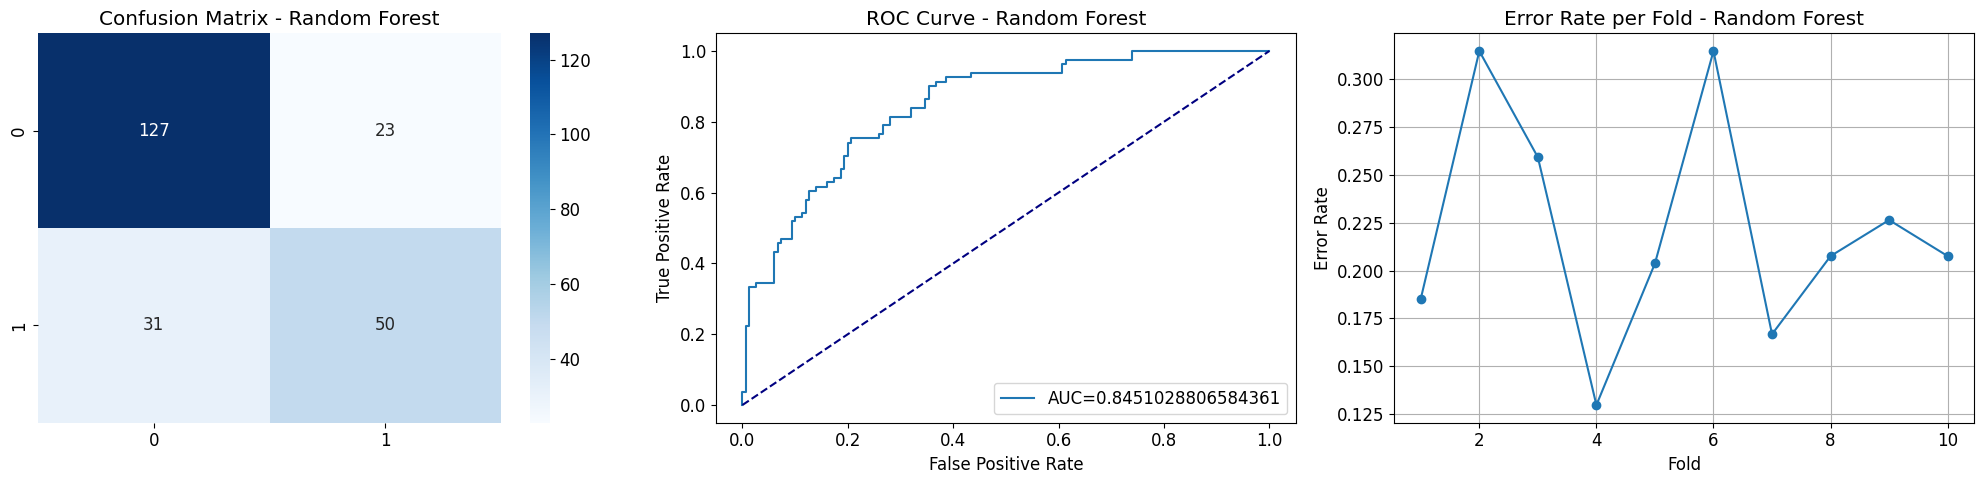

In [112]:
best_rf_model = grid_search_rf.best_estimator_

# Evaluate the best Random Forest model
rf_accuracy, rf_report, rf_conf_matrix, rf_model = evaluate_model(best_rf_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("Random Forest Accuracy:", rf_accuracy)
print(rf_report)

# Create subplots for Random Forest
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for Random Forest
sns.heatmap(pd.DataFrame(rf_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - Random Forest")

# Plot ROC Curve for Random Forest
plot_roc_curve(rf_model, X_test_scaled, y_test_scaled, ax[1], "Random Forest")

# Calculate and plot error rates during cross-validation for Random Forest
error_rates_rf = calculate_error_rates(rf_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_rf, ax[2], "Random Forest")

plt.tight_layout()
plt.show()

#**9. Decision Tree**

In [85]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Perform Grid Search for Decision Tree
dt = DecisionTreeClassifier(random_state=43)
grid_search_dt = GridSearchCV(dt, param_grid, cv=StratifiedKFold(n_splits=10), scoring='accuracy', n_jobs=-1)
grid_search_dt.fit(X_train_scaled, y_train_scaled)

# Print the best parameters and best model accuracy
print("Best Parameters for Decision Tree:", grid_search_dt.best_params_)

Best Parameters for Decision Tree: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10}


Decision Tree Accuracy: 0.7272727272727273
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       150
           1       0.63      0.53      0.58        81

    accuracy                           0.73       231
   macro avg       0.70      0.68      0.69       231
weighted avg       0.72      0.73      0.72       231



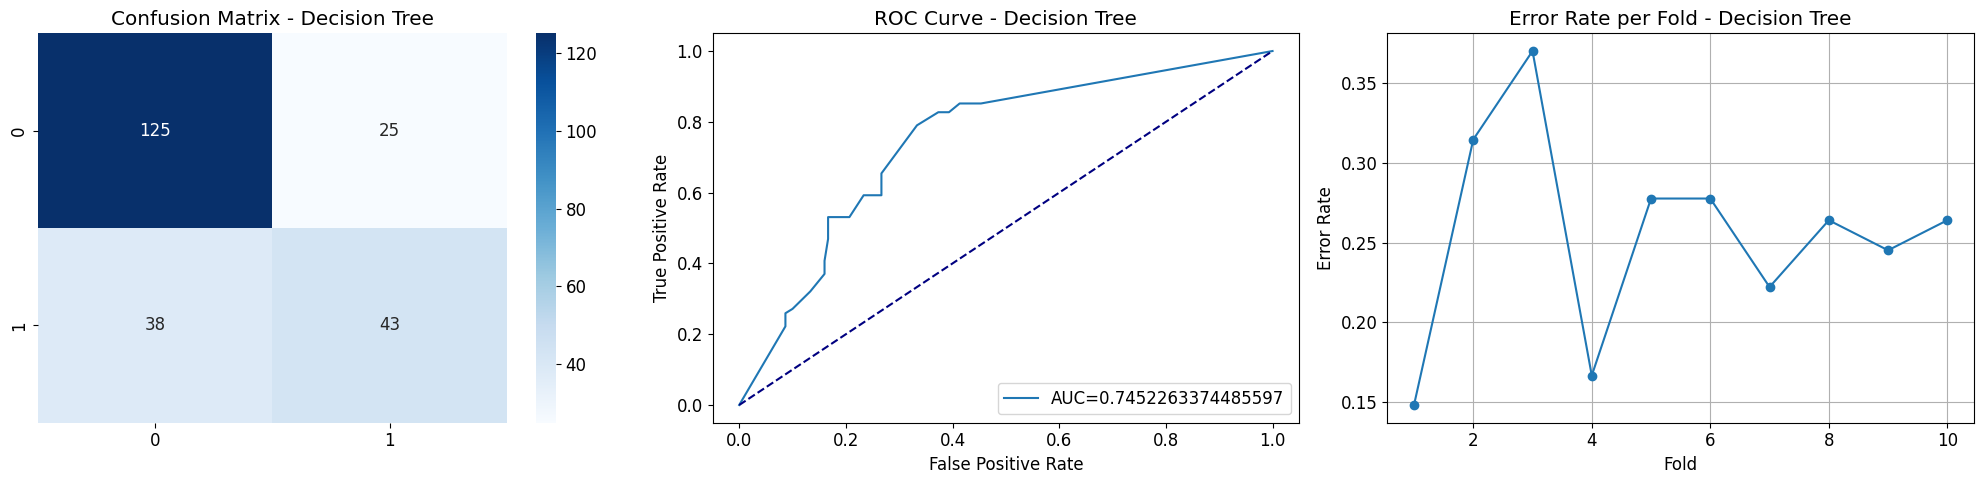

In [86]:
best_dt_model = grid_search_dt.best_estimator_

# Evaluate the best Decision Tree model
dt_accuracy, dt_report, dt_conf_matrix, dt_model = evaluate_model(best_dt_model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
print("Decision Tree Accuracy:", dt_accuracy)
print(dt_report)

# Create subplots for Decision Tree
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Plot Confusion Matrix for Decision Tree
sns.heatmap(pd.DataFrame(dt_conf_matrix), annot=True, cmap='Blues', fmt='d', ax=ax[0])
ax[0].set_title("Confusion Matrix - Decision Tree")

# Plot ROC Curve for Decision Tree
plot_roc_curve(dt_model, X_test_scaled, y_test_scaled, ax[1], "Decision Tree")

# Calculate and plot error rates during cross-validation for Decision Tree
error_rates_dt = calculate_error_rates(dt_model, X_train_scaled, y_train_scaled, cv=StratifiedKFold(n_splits=10))
plot_error_rates(error_rates_dt, ax[2], "Decision Tree")

plt.tight_layout()
plt.show()

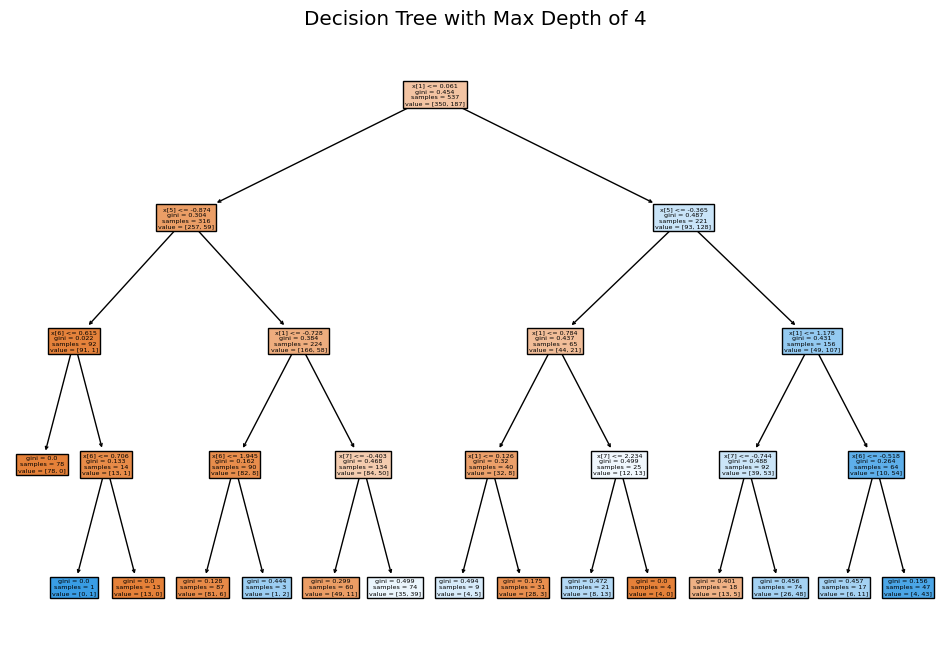

In [87]:
from sklearn.tree import plot_tree

# Create Decision Tree model with max depth of 4
dt_model_depth_4 = DecisionTreeClassifier(max_depth=4, random_state=43)
dt_model_depth_4.fit(X_train_scaled, y_train_scaled)

# Plot decision tree
plt.figure(figsize=(12, 8))
plot_tree(dt_model_depth_4, filled=True)
plt.title("Decision Tree with Max Depth of 4")
plt.show()


#**Comparison of Model Accuracies**

Naive Bayes Accuracy: 0.7835497835497836
KNN Accuracy: 0.7532467532467533
MLP Accuracy: 0.7922077922077922
SVM Accuracy: 0.7922077922077922
XGBoost Accuracy: 0.7532467532467533
Linear Discriminant Analysis Accuracy: 0.7705627705627706
Logistic Regression Accuracy: 0.7922077922077922
Random Forest Accuracy: 0.7662337662337663
Decision Tree Accuracy: 0.7272727272727273


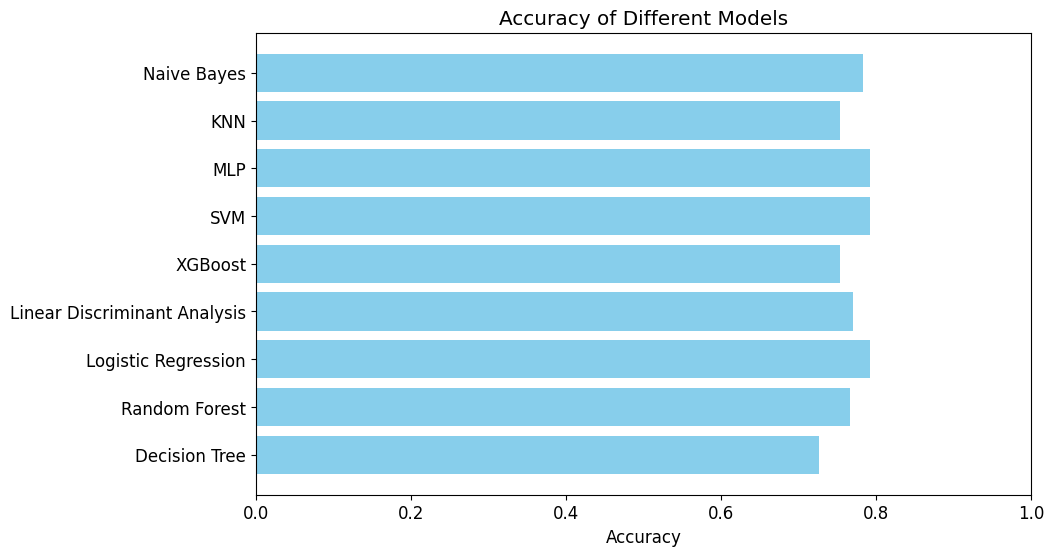

In [115]:
# List of models and their names
models = [nb_model, knn_model, mlp_model, svm_model, xgb_model, lda_model, log_reg_model, rf_model, dt_model]
model_names = ['Naive Bayes', 'KNN', 'MLP', 'SVM', 'XGBoost', 'Linear Discriminant Analysis', 'Logistic Regression', 'Random Forest', 'Decision Tree']

# Calculate accuracy for each model
accuracies = []
for model in models:
    accuracy, _, _, _ = evaluate_model(model, X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled)
    accuracies.append(accuracy)

# Print accuracies
for i, model_name in enumerate(model_names):
    print(f"{model_name} Accuracy: {accuracies[i]}")

# Plot accuracies
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies, color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xlim(0, 1)
plt.gca().invert_yaxis()  # Invert y-axis to display models from top to bottom
plt.show()